# Run edges-cal based pipeline to match the H2Case

In [1]:
from edges_cal.alanmode import acqplot7amoon, edges3cal
from pathlib import Path
from edges_cal.alanmode import read_s11_csv, read_spec_txt, read_specal, read_raul_s11_format, write_specal, write_modelled_s11s
import numpy as np
from astropy import units as un
from edges_cal.s11 import S11Model, LoadS11, Receiver
from edges_cal.tools import FrequencyRange
from edges_cal import modelling as mdl
import matplotlib.pyplot as plt

In [2]:
def read_s11m(pth):
    _s11m = np.genfromtxt(pth, comments="#", names=True)
    s11m = {}
    for load in loads + ['lna', 'rig_s11', 'rig_s12', 'rig_s22']:
        if load=='load':
            load = 'amb'
        s11m[load] = _s11m[f"{load}_real"] + 1j*_s11m[f"{load}_imag"]
    s11m['freq'] = _s11m['freq']
    return s11m

In [3]:
calobspath = Path("/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/Spectra")
s11fname = "data/s11_calibration_low_band_LNA25degC_2015-09-16-12-30-29_simulator2_long.txt"
outpath = Path("edges-cal-outputs")

In [4]:
loadspec_files = {
    'load': [calobspath/'Ambient_01_2015_245_02_00_00_lab.acq', calobspath/'Ambient_01_2015_246_02_00_00_lab.acq'],
    'hot': [calobspath/'HotLoad_01_2015_246_04_00_00_lab.acq', calobspath/'HotLoad_01_2015_247_00_00_00_lab.acq'],
    'open': [calobspath/'LongCableOpen_01_2015_243_14_00_00_lab.acq', calobspath/'LongCableOpen_01_2015_244_00_00_00_lab.acq', calobspath / 'LongCableOpen_01_2015_245_00_00_00_lab.acq'],
    'short':  [calobspath/'LongCableShorted_01_2015_241_04_00_00_lab.acq', calobspath/'LongCableShorted_01_2015_242_00_00_00_lab.acq', calobspath/'LongCableShorted_01_2015_243_00_00_00_lab.acq'],
}

In [5]:
loads = list(loadspec_files.keys())

## Check Modelling of S11's

In [6]:
alans11m = read_s11m("scripts/s11_modelled.txt")

In [7]:
raw_s11s = read_raul_s11_format(s11fname)

In [8]:
wfstart=50.0
wfstop=100.0
nfit2=27
nfit3=11

s11freq = FrequencyRange(
    raw_s11s['freq']*un.MHz, f_low=wfstart * un.MHz, f_high=wfstop * un.MHz
)

s11_models = {}
for name, s11 in raw_s11s.items():
    if name in ['freq', 'lna']: continue
    
    s11_models[name] = LoadS11(
        raw_s11=s11[s11freq.mask],
        freq=s11freq,
        n_terms=nfit2,
        model_type=mdl.Fourier,
        complex_model_type=mdl.ComplexRealImagModel,
        model_transform=mdl.ZerotooneTransform(range=(1, 2)),
        set_transform_range=True,
        fit_kwargs={"method": "alan-qrd"},
        internal_switch=None,
        model_kwargs={"period": 1.5},
    ).with_model_delay()

receiver = Receiver(
    raw_s11=raw_s11s['lna'][s11freq.mask],
    freq=s11freq,
    n_terms=nfit3,
    model_type=mdl.Fourier,
    complex_model_type=mdl.ComplexRealImagModel,
    model_transform=mdl.ZerotooneTransform(range=(1, 2)),
    # if nfit3 > 16
    # else mdl.Log10Transform(scale=120),
    set_transform_range=True,
    fit_kwargs={"method": "alan-qrd"},
    model_kwargs={"period": 1.5}
).with_model_delay()

In [11]:
from edges_cal.loss import HotLoadCorrection

In [12]:
mdlopts = {
    "transform": (
        mdl.ZerotooneTransform(
            range=(s11freq.min.to_value("MHz"), s11freq.max.to_value("MHz"))
        )
    ),
    "n_terms": nfit2,
    'period': 1.5
}


hot_loss_model = HotLoadCorrection(
    freq=s11freq,
    raw_s11=raw_s11s['s11rig'],
    raw_s12s21=raw_s11s['s12rig'],
    raw_s22=raw_s11s['s22rig'],
    model=mdl.Fourier(**mdlopts),
    complex_model=mdl.ComplexRealImagModel,
)


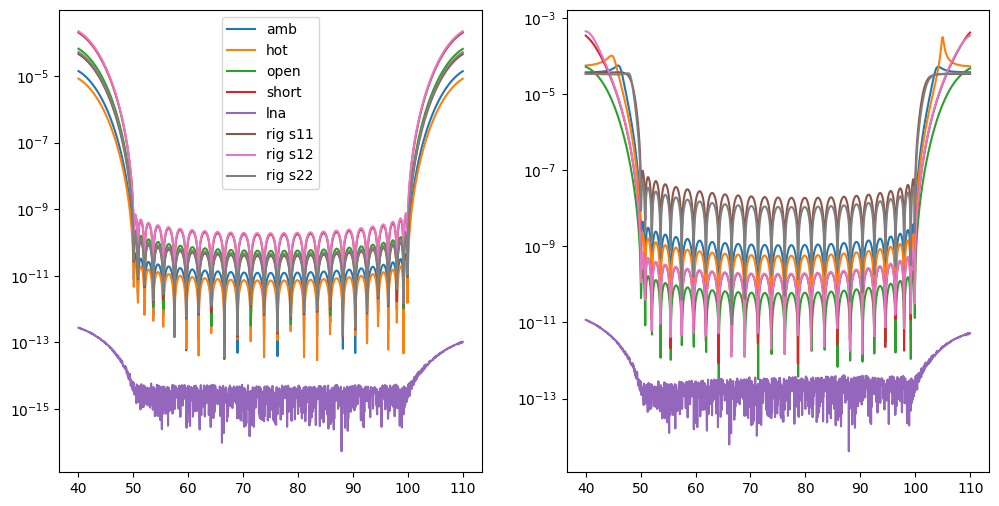

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

for name, s11 in alans11m.items():
    if name=="freq" or name.startswith('rig'): continue
    
    if name == 'lna':
        ours = receiver.s11_model(alans11m['freq'])
    else:
        ours = s11_models[name].s11_model(alans11m['freq'])
        
    ax[0].plot(alans11m['freq'], np.abs(s11 - ours), label=name)
    ax[1].plot(alans11m['freq'], np.abs(s11 - ours)/np.abs(s11), label=name)

ours = hot_loss_model.s11_model(alans11m['freq'])
ax[0].plot(alans11m['freq'], np.abs(alans11m['rig_s11'] - ours), label='rig s11')
ax[1].plot(alans11m['freq'], np.abs(alans11m['rig_s11'] - ours)/np.abs(alans11m['rig_s11']), label='rig s11')

ours = hot_loss_model.s12s21_model(alans11m['freq'])
ax[0].plot(alans11m['freq'], np.abs(alans11m['rig_s12'] - ours), label='rig s12')
ax[1].plot(alans11m['freq'], np.abs(alans11m['rig_s12'] - ours)/np.abs(alans11m['rig_s12']), label='rig s12')

ours = hot_loss_model.s22_model(alans11m['freq'])
ax[0].plot(alans11m['freq'], np.abs(alans11m['rig_s22'] - ours), label='rig s22')
ax[1].plot(alans11m['freq'], np.abs(alans11m['rig_s22'] - ours)/np.abs(alans11m['rig_s22']), label='rig s22')
           
ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')


In [14]:
opts = dict(
    fstart=40.0,
    fstop=110.0,
    wfstart=50.0,
    wfstop=100.0,
    smooth = 8,
    tload = 300.0,
    tcal = 1000.0,
    nrfi = 0,
    tstart = 0,
    tstop = 23,
    delaystart = 7200,
)


In [15]:
if not (outpath / 'spe_hotr.txt').exists():
    for load, files in loadspec_files.items():
        freq, n, t = acqplot7amoon(
            acqfile = files,
            **opts
        )

        outfile = outpath / f"spe_{load}r.txt"
        with open(outfile, "w") as fl:
            for i, (f, spec) in enumerate(zip(freq, t)):
                f = f.to_value("MHz")
                if i == 0:
                    fl.write(f"{f:12.6f} {spec:12.6f} {1:4.0f} {n} // temp.acq\n")
                else:
                    fl.write(f"{f:12.6f} {spec:12.6f} {1:4.0f}\n")


In [16]:
alanspec = {}
ourspec = {}
for load in loads:
    data = read_spec_txt(f"scripts/H2Case/spe_{load}r.txt")
    spfreq = data['freq']
    alanspec[load] = data['spectra']
    data = read_spec_txt(outpath / f"spe_{load}r.txt")
    ourspec[load] = data['spectra']
    assert np.allclose(spfreq, data['freq'])

Text(0.5, 0.98, 'Raw spectra differences')

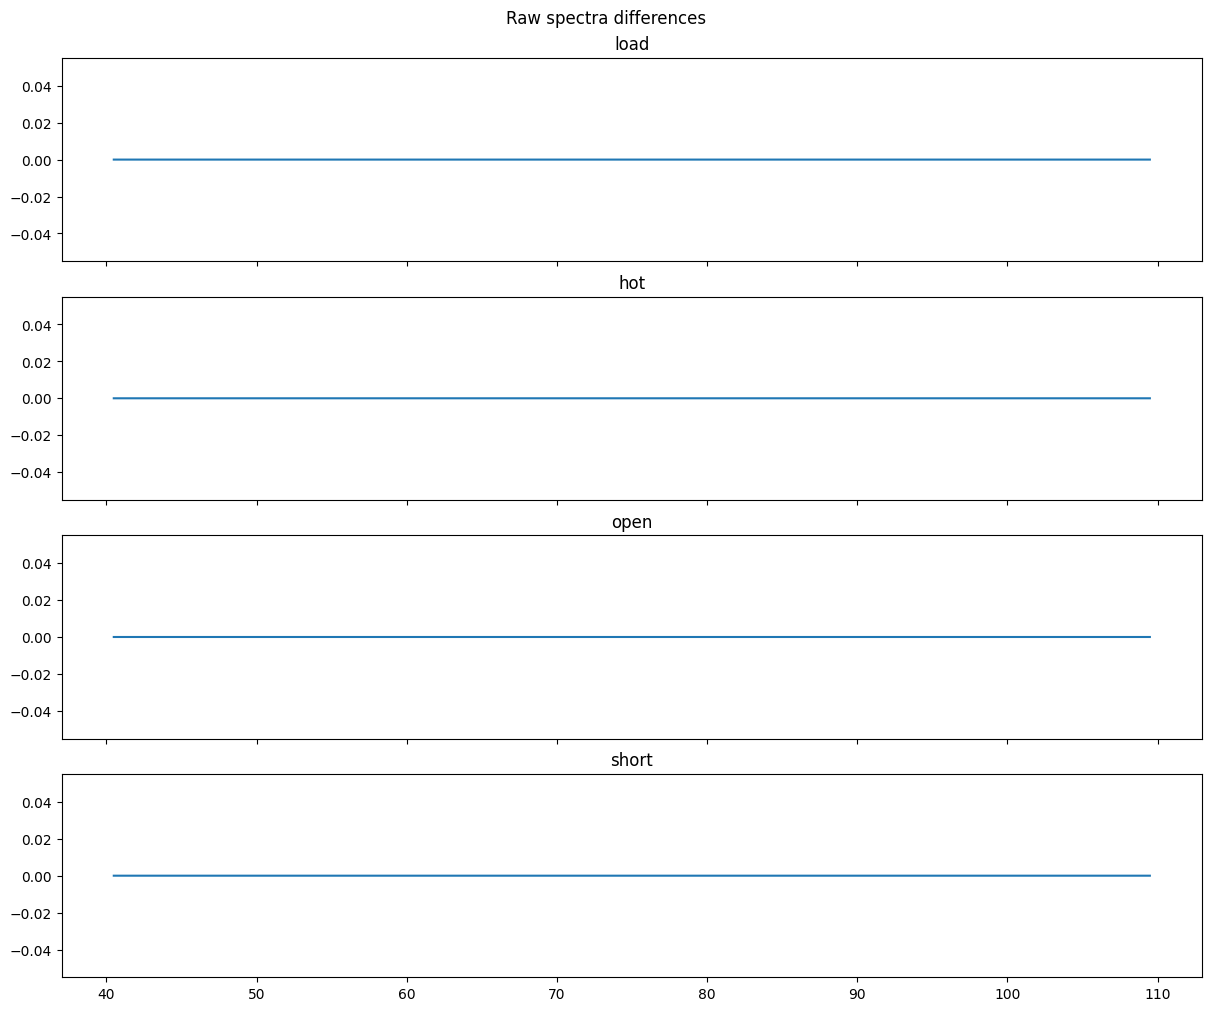

In [17]:
fig, ax = plt.subplots(len(alanspec), 1, sharex=True, constrained_layout=True, figsize=(12, 10))
for i, load in enumerate(alanspec):
    ax[i].plot(spfreq[10:-10], alanspec[load][10:-10] - ourspec[load][10:-10])
    ax[i].set_title(load)
    
fig.suptitle("Raw spectra differences")

In [19]:
calobs = edges3cal(
    spfreq=spfreq*un.MHz,
    spcold=ourspec['load'],
    sphot=ourspec['hot'],
    spopen=ourspec['open'],
    spshort=ourspec['short'],
    s11freq=raw_s11s['freq']*un.MHz,
    s11hot=raw_s11s['hot'],
    s11cold=raw_s11s['amb'],
    s11lna=raw_s11s['lna'],
    s11open=raw_s11s['open'],
    s11short=raw_s11s['short'],
    Lh=-2, #Path("scripts/hot_load_loss.txt"), #-2,
    wfstart=50,
    wfstop=100,
    tcold=296,
    thot=399,
    cfit=6,
    wfit=5,
    nfit2=27,
    nfit3=11,
    s11rig=raw_s11s['s11rig'],
    s12rig=raw_s11s['s12rig'],
    s22rig=raw_s11s['s22rig'],
    edges2kmode=True,
    lna_poly=0,
    # nfit1 = 27, # I don't think this is actually used
    # mfit = 3,   # I don't think this is actually used.
    # nfit4 = 27  # Used for the antenna (so not here)
    # lmode = 2,  # Used for the antenna (so not here)
    # smooth=8,   # only used for output plots, os not useful here
)

In [19]:
calobs_inj = calobs.inject(
    lna_s11=alans11m["lna"][alanmask],
    source_s11s={
        "ambient": alans11m["amb"][alanmask],
        "hot_load": alans11m["hot"][alanmask],
        "short": alans11m["short"][alanmask],
        "open": alans11m["open"][alanmask],
    }
)


NameError: name 'alanmask' is not defined

In [20]:
write_specal(calobs, outpath/'specal.txt')
#write_specal(calobs_inj, outpath/'specal-injected.txt')

In [21]:
write_modelled_s11s(calobs, outpath/'s11_modelled.txt')


In [22]:
ourcal = read_specal(outpath / 'specal.txt')
#ourcalinj = read_specal(outpath / 'specal-injected.txt')


In [23]:
alancal = read_specal("scripts/H2Case/specal.txt")

In [24]:
alanmask = alancal['weight']>0

In [25]:
alancal = alancal[alanmask]

In [26]:
def plot_calcoeff_cases(cases, comp_case, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(len(comp_case.dtype.names)-2, 1, sharex=True, constrained_layout=True, figsize=(12, 15))

    for ic, (case, cal) in enumerate(cases.items()):
        j = 0
        
        for i, name in enumerate(comp_case.dtype.names):
            if name in ('freq', 'weight'):
                continue
                
            ax[j].plot(comp_case['freq'], np.abs(comp_case[name] - cal[name]), label=case, ls=(ic, (5, 4)))
            
            ax[j].set_yscale('log')
            ax[j].set_title(name)
            j += 1

    ax[0].legend()
    return fig, ax

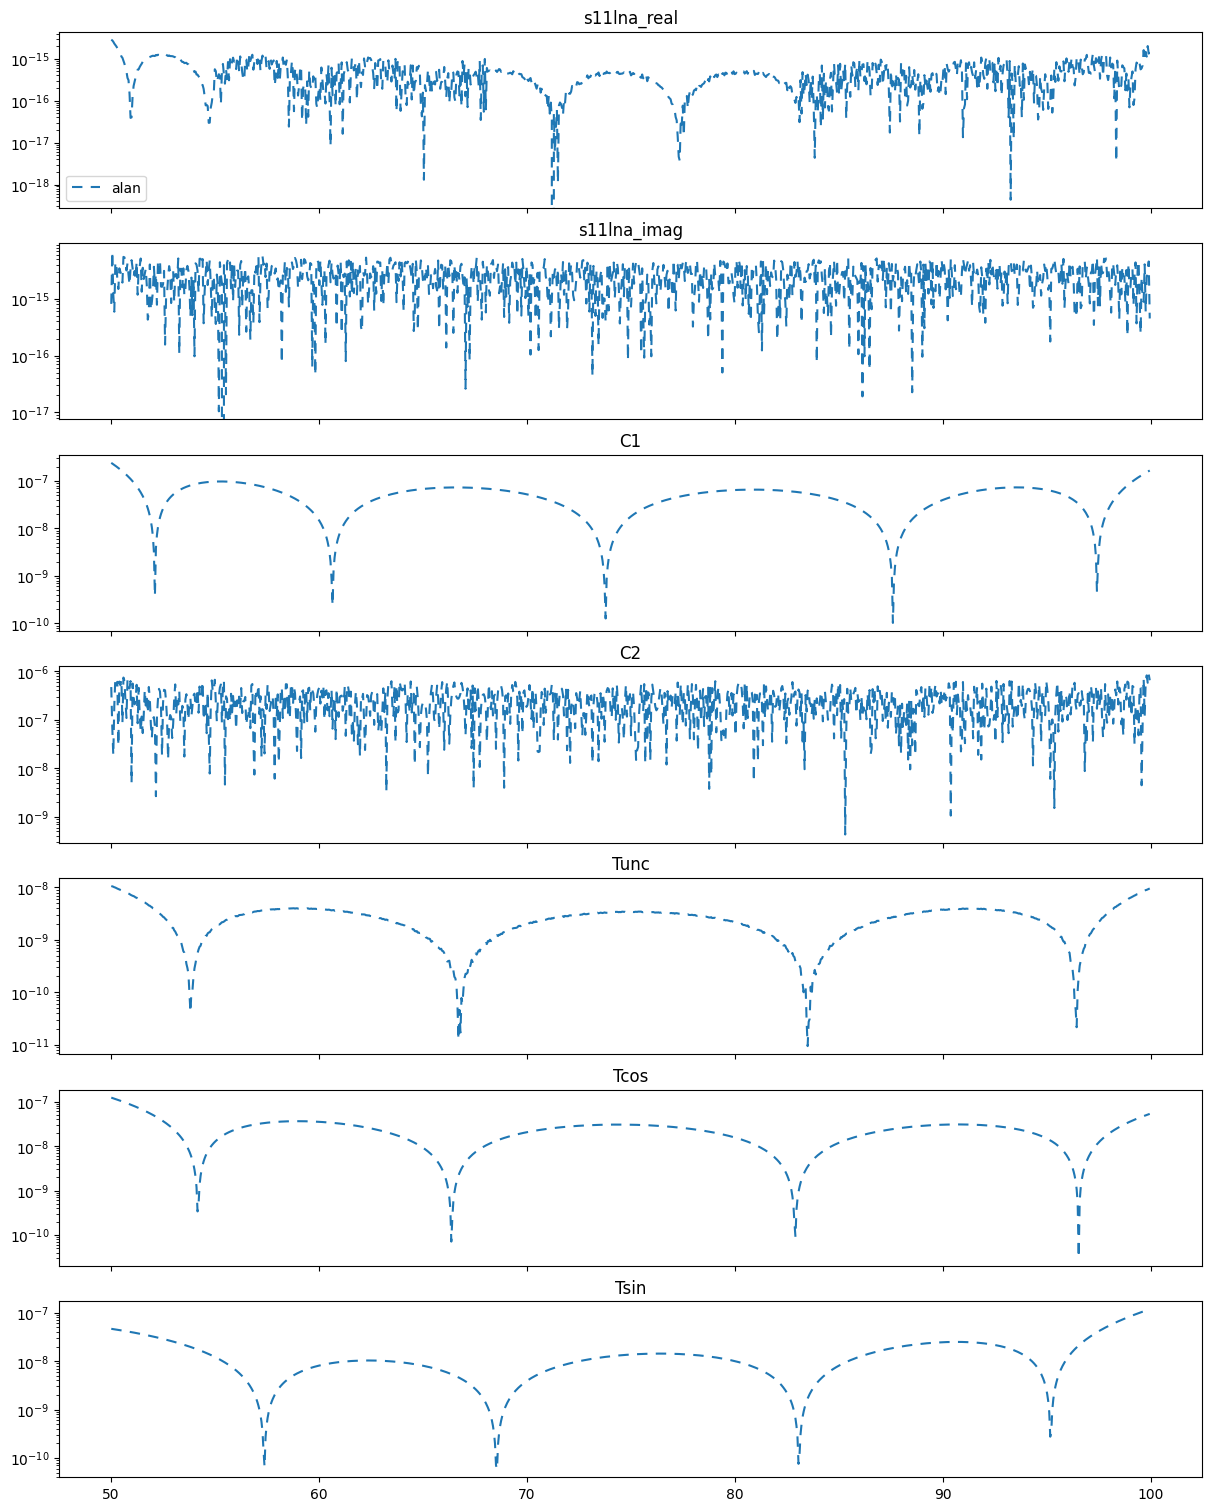

In [27]:
plot_calcoeff_cases({"alan": alancal}, ourcal);

In [61]:
ours11m = read_s11m(outpath / "s11_modelled.txt")

ValueError: no field of name rig_s11_real

In [39]:
calobs.hot_load.loss_model(calobs.freq.freq, calobs.hot_load.reflections.s11_model(calobs.freq.freq))

array([0.16699307, 0.16487762, 0.16283035, ..., 0.2272122 , 0.22847607,
       0.22976129])

In [28]:
alans_hot_load_loss = np.genfromtxt("scripts/hot_load_loss.txt")

(50.0, 100.0)

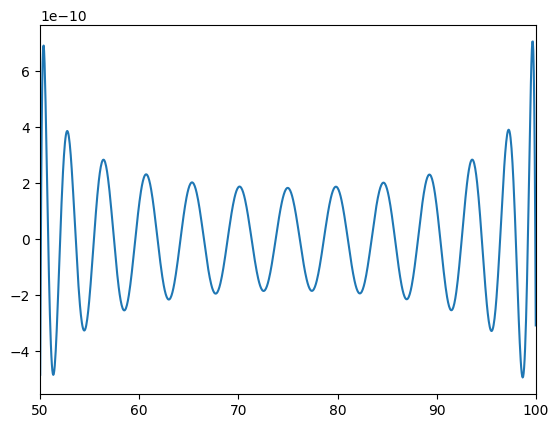

In [29]:
#plt.plot(alans_hot_load_loss[:,0], alans_hot_load_loss[:, 1])
plt.plot(calobs.freq.freq, calobs.hot_load.loss_model(calobs.freq.freq, calobs.hot_load.reflections.s11_model(calobs.freq.freq)) / alans_hot_load_loss[alanmask, 1] - 1)
plt.xlim(50,100)
#plt.yscale('log')
#plt.ylim(0.99, 1.0)

NameError: name 'ours11m' is not defined

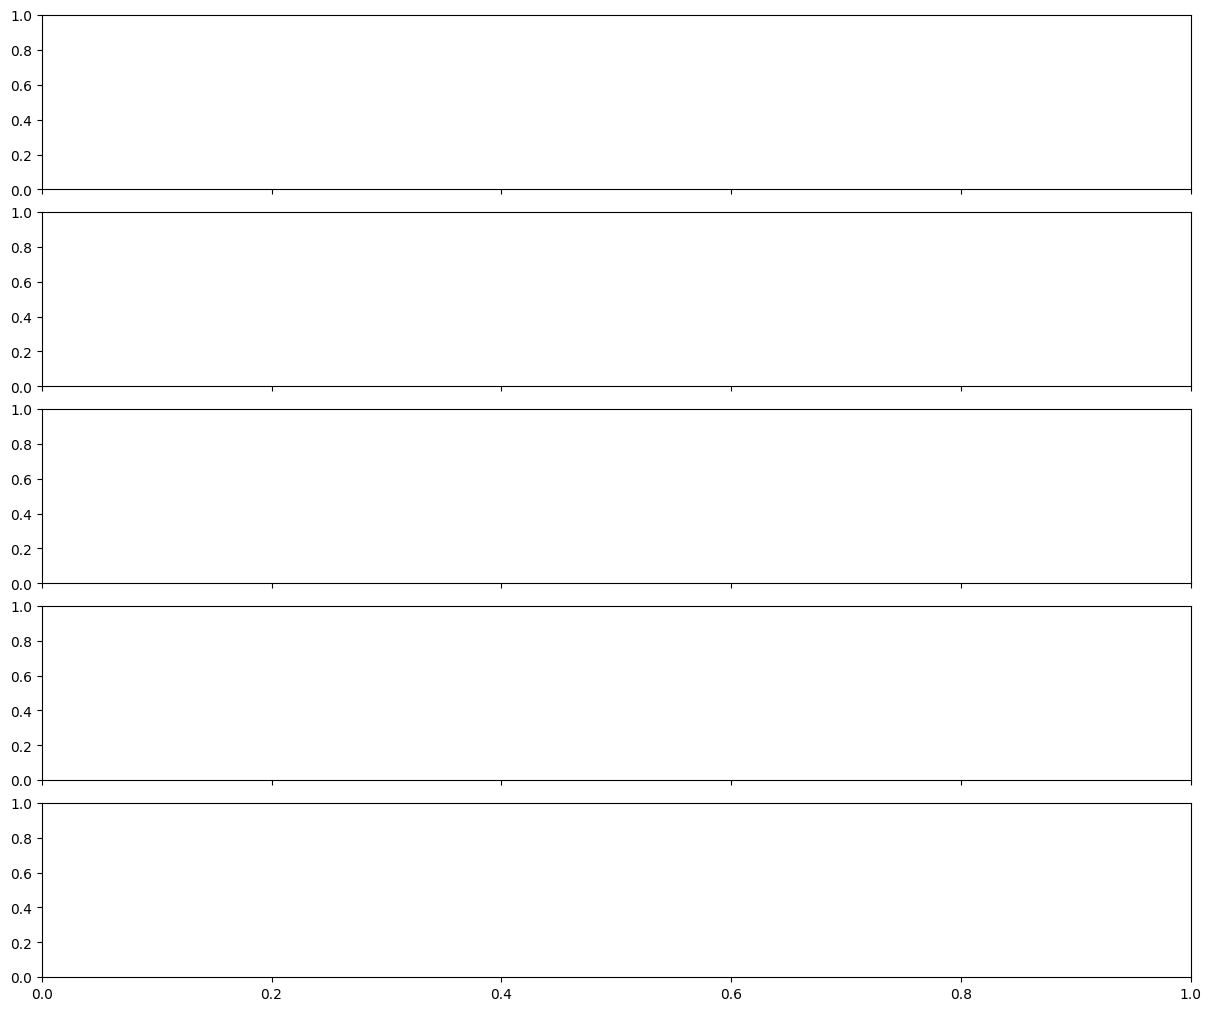

In [60]:

fig, ax = plt.subplots(len(loads) + 1, 1, sharex=True, constrained_layout=True, figsize=(12, 10))

for i, load in enumerate(loads + ['lna']):
    if load =='load':
        load='amb'
    ax[i].plot(ours11m['freq'], np.abs(ours11m[load] - alans11m[load]))
    ax[i].set_title(load)
    ax[i].set_yscale('log')
ax[0].legend(ncols=4)
